## Imports

In [310]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

# keras imports for the dataset and building our neural network
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
import tensorflow as tf
import pdb
# Read in the training CSV file
print( "Reading Training csv file.")
df1 = pd.read_csv("UNSW_NB15_training-set.csv")
df1.drop('label', axis=1, inplace=True)

#One hot encoding the string variables
obj_df1=df1
obj_df1["proto"] = obj_df1["proto"].astype('category')
obj_df1["service"] = obj_df1["service"].astype('category')
obj_df1["state"] = obj_df1["state"].astype('category')
obj_df1["proto_cat"] = obj_df1["proto"].cat.codes
obj_df1["service_cat"] = obj_df1["service"].cat.codes
obj_df1["state_cat"] = obj_df1["state"].cat.codes

obj_df1["proto"] = obj_df1["proto_cat"]
obj_df1["service"] = obj_df1["service_cat"]
obj_df1["state"] = obj_df1["state_cat"]

obj_df1.drop('proto_cat', axis=1, inplace=True)
obj_df1.drop('service_cat', axis=1, inplace=True)
obj_df1.drop('state_cat', axis=1, inplace=True)

Y_train_all_attacks = obj_df1["attack_cat"]
X_train = obj_df1.values[:,:-1]

#Normalizing train set
for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_train)):
        X_train[i,j] = round(X_train[i,j]/maximum,3)

#Make a catagorical cloumn for each type of label in trainset
obj_df1=pd.get_dummies(obj_df1, columns=["attack_cat"])
Y_train_each_attach = obj_df1.values[:,-10:]
        
# Read in the testing CSV file 
print("Reading Testing csv file.")
df2 = pd.read_csv("UNSW_NB15_testing-set.csv")
df2.drop('label', axis=1, inplace=True)

#One hot encoding the string variables
obj_df2=df2
obj_df2["proto"] = obj_df2["proto"].astype('category')
obj_df2["service"] = obj_df2["service"].astype('category')
obj_df2["state"] = obj_df2["state"].astype('category')
obj_df2["proto_cat"] = obj_df2["proto"].cat.codes
obj_df2["service_cat"] = obj_df2["service"].cat.codes
obj_df2["state_cat"] = obj_df2["state"].cat.codes

obj_df2["proto"] = obj_df2["proto_cat"]
obj_df2["service"] = obj_df2["service_cat"]
obj_df2["state"] = obj_df2["state_cat"]

obj_df2.drop('proto_cat', axis=1, inplace=True)
obj_df2.drop('service_cat', axis=1, inplace=True)
obj_df2.drop('state_cat', axis=1, inplace=True)

Y_test_all_attacks = obj_df2["attack_cat"]
X_test = obj_df2.values[:,:-1]

#Normalizing test set
for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_test)):
        X_test[i,j] = round(X_test[i,j]/maximum,3)
        
#Make a catagorical cloumn for each type of label in testset
obj_df2=pd.get_dummies(obj_df2, columns=["attack_cat"])
Y_test_each_attach = obj_df2.values[:,-10:]

cleanup_nums = {"Worms":0, "Shellcode":1, "Reconnaissance":2, "Normal":3, "Generic":4, "Fuzzers":5, "Exploits":6, "DoS":7, "Backdoor":8, "Analysis":9}
Y_train_all_attacks.replace(cleanup_nums,inplace=True)
Y_test_all_attacks.replace(cleanup_nums,inplace=True)
print('Trainset size: ',X_train.shape,Y_train_all_attacks.shape,'Testset size: ',X_test.shape,Y_test_all_attacks.shape)
Y_train = Y_train_all_attacks 
Y_test = Y_test_all_attacks

Reading Training csv file.
Reading Testing csv file.
Trainset size:  (175341, 43) (175341,) Testset size:  (82332, 43) (82332,)


## Encode labels

In [311]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Shape before one-hot encoding:  (175341,)
Shape after one-hot encoding:  (175341, 10)


## 1. Build a classifier and training.

In [312]:
# building a linear stack of layers with the sequential model
# Sparsity is only applied to the weights. Biases are kept aside out of sparsity.
#machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

model = Sequential()
model.add(Dense(160, input_shape=(43,)))
model.add(Activation('relu'))                            

model.add(Dense(80))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.batches = []
        self.weight_save = []
        self.model_weights = model.get_weights()
        self.weight_masks = []
        for i in range(len(self.model_weights)):
            if i%2 == 0:
                self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.weight_masks.append(self.random_mask)
        for i in range(len(self.model_weights)):
            if i %2 == 0:
                self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
        model.set_weights(self.model_weights)
        self.weight_save.append(model.get_weights)       

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.batches.append(batch)
        self.model_weights = model.get_weights()
        for i in range(len(self.model_weights)):
            if i %2 == 0:
                self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
        model.set_weights(self.model_weights)
        self.weight_save.append(model.get_weights) 
       
                
l_history=LossHistory()
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=10, verbose=1,
          validation_data=(X_test, Y_test), callbacks = [es, l_history])

# saving the model
model_name = 'keras_unsw.h5'
model.save(model_name)
print('Saved trained model %s ' % model_name)

Epoch 1/10
1370/1370 [==============================] - 9s 6ms/step - loss: 1.8560 - accuracy: 0.3122 - val_loss: 14360707.0000 - val_accuracy: 0.0240
Epoch 2/10
1370/1370 [==============================] - 7s 5ms/step - loss: 1.6667 - accuracy: 0.3193 - val_loss: 12353677.0000 - val_accuracy: 0.0049
Epoch 3/10
1370/1370 [==============================] - 6s 4ms/step - loss: 1.5553 - accuracy: 0.4275 - val_loss: 9394613.0000 - val_accuracy: 0.0049
Epoch 4/10
1370/1370 [==============================] - 6s 5ms/step - loss: 1.4710 - accuracy: 0.5466 - val_loss: 7613782.5000 - val_accuracy: 0.0049
Epoch 5/10
1370/1370 [==============================] - 6s 4ms/step - loss: 1.4509 - accuracy: 0.5469 - val_loss: 6318953.5000 - val_accuracy: 0.0049
Epoch 6/10
1370/1370 [==============================] - 7s 5ms/step - loss: 1.4418 - accuracy: 0.5447 - val_loss: 5516721.5000 - val_accuracy: 0.0049
Epoch 7/10
1370/1370 [==============================] - 8s 6ms/step - loss: 1.4362 - accuracy: 0.5

#### Ploting the model performance.

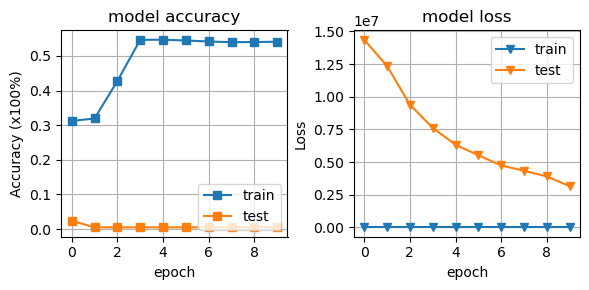

In [313]:
# plotting the metrics
fig = plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], marker = 's')
plt.plot(history.history['val_accuracy'], marker = 's')
plt.title('model accuracy')
plt.ylabel('Accuracy (x100%)')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], marker = 'v')
plt.plot(history.history['val_loss'], marker = 'v')
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()


In [314]:
len(l_history.weight_masks)

#### Sparsity percentage vs accuracy

In [315]:
#Sparsity percentage in each layer
for i in range(len(l_history.weight_masks)):
    print(f'sparsity in {i+1}th layer measured from mask:', 1-(np.count_nonzero(l_history.weight_masks[i])+0.0)/l_history.weight_masks[i].size)
    
print("---------------------------------------------------------------")    
for i in range(len(model.get_weights())):
    if i%2==0:
        print(f'Verification, sparsity in {i}th array from model.get_weights():',1-(np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)

sparsity in 1th layer measured from mask: 0.9715116279069768
sparsity in 2th layer measured from mask: 0.971171875
sparsity in 3th layer measured from mask: 0.9725
---------------------------------------------------------------
Verification, sparsity in 0th array from model.get_weights(): 0.9715116279069768
Verification, sparsity in 2th array from model.get_weights(): 0.971171875
Verification, sparsity in 4th array from model.get_weights(): 0.9725


#### Evaluating model performance

In [316]:
mnist_model = load_model(model_name)
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss {}.".format(loss_and_metrics[0]))
print("Test Accuracy {}%".format(loss_and_metrics[1]*100))

2573/2573 - 2s - loss: 3148421.7500 - accuracy: 0.0049 - 2s/epoch - 736us/step
Test Loss 3148421.75.
Test Accuracy 0.49069621600210667%


#### Re-load the trained model to evaluate it further.

In [318]:
# load the model and create predictions on the test set
mnist_model = load_model(model_name)
predicted_classes = np.argmax(mnist_model.predict(X_test), axis=1)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

2573/2573 [==============================] - 2s 723us/step
0  classified correctly
1  classified incorrectly


C:\Users\rrk307\AppData\Local\Temp\ipykernel_21296\3876953921.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_indices = np.nonzero(predicted_classes == y_test)[0]
C:\Users\rrk307\AppData\Local\Temp\ipykernel_21296\3876953921.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  incorrect_indices = np.nonzero(predicted_classes != y_test)[0]


## 2. Experimentation: Different sparsity and model performance measurement

In [326]:
#Sweeping the sparsity and measuring the model accuracy

model = Sequential()
model.add(Dense(160, input_shape=(43,),kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Activation('relu'))                            
model.add(Dense(80,kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(Dense(10,kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model_losses = []
model_accs = []
layerwise_sparsity = []
Layerwise_sparsity = []
model_sparsity = []
sparsity_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99]
for sparsity in sparsity_range:
    print('Model training for sparsity # {0}'.format(sparsity))
    class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if i%2 == 0:
                    self.random_mask = np.ones(self.model_weights[i].shape)
                    self.random_mask[:int(self.model_weights[i].shape[0]*sparsity),:] = 0
                    shape_save =self.random_mask.shape
                    self.random_mask = self.random_mask.ravel().tolist()
                    random.shuffle(self.random_mask) 
                    self.random_mask = np.asarray(self.random_mask).reshape(shape_save)
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)        

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 

    l_history=LossHistory()
    history = model.fit(X_train, Y_train,
              batch_size=128, epochs=10, verbose=0,
              validation_data=(X_test, Y_test), callbacks = [es, l_history])

    loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
    model_losses.append(loss_and_metrics[0])
    model_accs.append(loss_and_metrics[1])
    
    for i in range(len(model.get_weights())):
        if i%2==0:
            layerwise_sparsity.append(1 - (np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)
    model_sparsity.append(np.mean(layerwise_sparsity))
    Layerwise_sparsity.append(layerwise_sparsity)
    layerwise_sparsity = []


Model training for sparsity # 0
2573/2573 - 2s - loss: 589722880.0000 - accuracy: 0.3885 - 2s/epoch - 873us/step
Model training for sparsity # 0.1
2573/2573 - 2s - loss: 950459776.0000 - accuracy: 0.3028 - 2s/epoch - 681us/step
Model training for sparsity # 0.2
2573/2573 - 2s - loss: 1190162176.0000 - accuracy: 0.1875 - 2s/epoch - 722us/step
Model training for sparsity # 0.3
2573/2573 - 2s - loss: 806817728.0000 - accuracy: 0.3118 - 2s/epoch - 674us/step
Model training for sparsity # 0.4
2573/2573 - 2s - loss: 1280116992.0000 - accuracy: 0.0311 - 2s/epoch - 689us/step
Model training for sparsity # 0.5
2573/2573 - 2s - loss: 1515863424.0000 - accuracy: 0.4268 - 2s/epoch - 699us/step
Model training for sparsity # 0.6
2573/2573 - 2s - loss: 614461504.0000 - accuracy: 0.3646 - 2s/epoch - 941us/step
Model training for sparsity # 0.7
2573/2573 - 2s - loss: 385028576.0000 - accuracy: 0.4072 - 2s/epoch - 961us/step
Model training for sparsity # 0.8
2573/2573 - 2s - loss: 688057728.0000 - accur

In [327]:
for (i,j,k) in zip(model_sparsity,model_accs,model_losses):
    print(f'sparsity = {round(i,5)}, Test accuracy = {round(j,5)}, Test loss = {round(k,5)}')

sparsity = 0.0, Test accuracy = 0.38845, Test loss = 589722880.0
sparsity = 0.09767, Test accuracy = 0.30285, Test loss = 950459776.0
sparsity = 0.20871, Test accuracy = 0.18752, Test loss = 1190162176.0
sparsity = 0.31818, Test accuracy = 0.3118, Test loss = 806817728.0
sparsity = 0.42612, Test accuracy = 0.03108, Test loss = 1280116992.0
sparsity = 0.53297, Test accuracy = 0.42683, Test loss = 1515863424.0
sparsity = 0.64265, Test accuracy = 0.36465, Test loss = 614461504.0
sparsity = 0.74961, Test accuracy = 0.4072, Test loss = 385028576.0
sparsity = 0.84077, Test accuracy = 0.23578, Test loss = 688057728.0
sparsity = 0.92334, Test accuracy = 0.09239, Test loss = 342167392.0
sparsity = 0.95309, Test accuracy = 0.20593, Test loss = 878907840.0
sparsity = 0.96762, Test accuracy = 0.41476, Test loss = 159590240.0
sparsity = 0.9774, Test accuracy = 0.43076, Test loss = 138665120.0
sparsity = 0.99364, Test accuracy = 0.27033, Test loss = 48.61727
sparsity = 0.99666, Test accuracy = 0.441

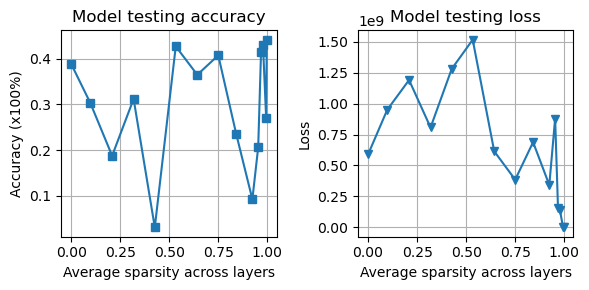

In [328]:
# plotting the metrics
fig = plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plt.plot(model_sparsity, model_accs, marker = 's')
plt.title('Model testing accuracy')
plt.grid()
plt.ylabel('Accuracy (x100%)')
plt.xlabel('Average sparsity across layers')

plt.subplot(1,2,2)
plt.plot(model_sparsity, model_losses, marker = 'v')
plt.title('Model testing loss')
plt.ylabel('Loss')
plt.xlabel('Average sparsity across layers')
plt.grid()
plt.tight_layout()

## 3. Rewiring the connections in sparse model. (sparsity = 0.9774)

In [329]:
import random
import pdb
Rewiring_dict = {}
saved_mask_from_iter1 = []
for re_wiring_iter in range(10):
    print('Training for re-wiring iteration: ', re_wiring_iter)
    model = Sequential()
    model.add(Dense(160, input_shape=(43,),kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Activation('relu'))                            
    model.add(Dense(80,kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(Dense(10,kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    sparsity = 0.9774
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=50)

    class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if int(i%2) == 0:
                    if re_wiring_iter == 0:
                        self.random_mask = np.ones(self.model_weights[i].shape)
                        self.random_mask[:int(self.model_weights[i].shape[0]*sparsity),:] = 0
                        shape_save =self.random_mask.shape
                        self.random_mask = self.random_mask.ravel().tolist()
                        random.shuffle(self.random_mask) 
                        self.random_mask = np.asarray(self.random_mask).reshape(shape_save)
                        saved_mask_from_iter1.append(self.random_mask)
                    else:
                        self.random_mask = saved_mask_from_iter1[int(i/2)].copy()
                        shape_save =self.random_mask.shape
                        self.random_mask = self.random_mask.ravel().tolist()
                        random.shuffle(self.random_mask) 
                        self.random_mask = np.asarray(self.random_mask).reshape(shape_save)
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)       

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 

    l_history=LossHistory()
    history = model.fit(X_train, Y_train,
              batch_size=128, epochs=10, verbose=0,
              validation_data=(X_test, Y_test), callbacks = [es, l_history])

    #Sparsity percentage in each layer 
    Rewiring_dict[re_wiring_iter] = []
    for i in range(len(l_history.weight_masks)):
        print(f'sparsity in {i+1}th layer measured from mask:', 1-(np.count_nonzero(l_history.weight_masks[i])+0.0)/l_history.weight_masks[i].size)
        Rewiring_dict[re_wiring_iter].append(np.unique(l_history.weight_masks[i], return_counts=True))
    print("----------")    
    for i in range(len(model.get_weights())):
        if i%2==0:
            print(f'Verification, sparsity in {i}th array from model.get_weights():',1-(np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)

    loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

    print("Test Loss {}.".format(loss_and_metrics[0]))
    print("Test Accuracy {}%".format(loss_and_metrics[1]*100))
    Rewiring_dict[re_wiring_iter].append(loss_and_metrics)
    Rewiring_dict[re_wiring_iter].append(model.get_weights())
    print("......................................................")   

Training for re-wiring iteration:  0
sparsity in 1th layer measured from mask: 0.9767441860465116
sparsity in 2th layer measured from mask: 0.975
sparsity in 3th layer measured from mask: 0.975
----------
Verification, sparsity in 0th array from model.get_weights(): 0.9767441860465116
Verification, sparsity in 2th array from model.get_weights(): 0.975
Verification, sparsity in 4th array from model.get_weights(): 0.975
2573/2573 - 2s - loss: 3148421.7500 - accuracy: 0.0049 - 2s/epoch - 808us/step
Test Loss 3148421.75.
Test Accuracy 0.49069621600210667%
......................................................
Training for re-wiring iteration:  1
sparsity in 1th layer measured from mask: 0.9767441860465116
sparsity in 2th layer measured from mask: 0.975
sparsity in 3th layer measured from mask: 0.975
----------
Verification, sparsity in 0th array from model.get_weights(): 0.9767441860465116
Verification, sparsity in 2th array from model.get_weights(): 0.975
Verification, sparsity in 4th arr

###### Plotting the model's and re-wiring metrics.

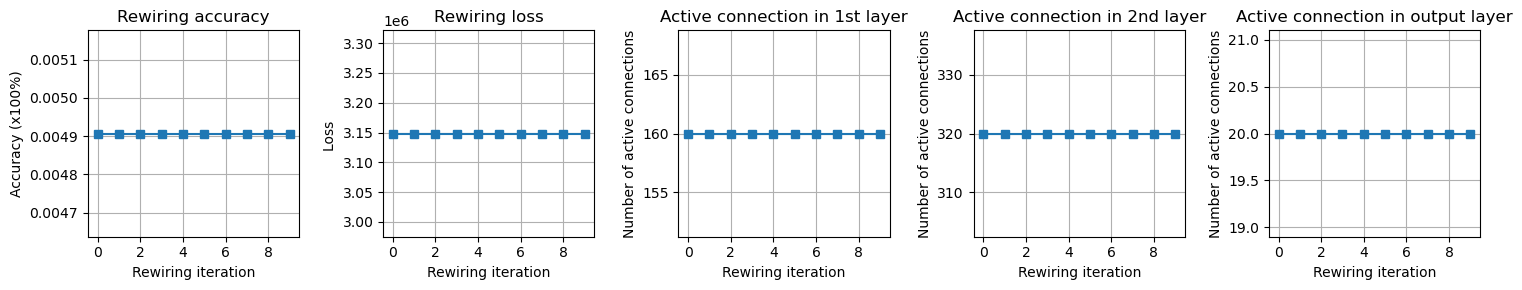

In [330]:
fig = plt.figure(figsize = (15,3))
plt.subplot(1,5,1)
plt.plot(list(range(10)), [Rewiring_dict[i][-2][1] for i in range(10)], marker = 's')
plt.title('Rewiring accuracy')
plt.grid()
plt.ylabel('Accuracy (x100%)')
plt.xlabel('Rewiring iteration')

plt.subplot(1,5,2)
plt.plot(list(range(10)), [Rewiring_dict[i][-2][0] for i in range(10)], marker = 's')
plt.title('Rewiring loss')
plt.grid()
plt.ylabel('Loss ')
plt.xlabel('Rewiring iteration')

plt.subplot(1,5,3)
plt.plot(list(range(10)), [Rewiring_dict[i][0][1][1] for i in range(10)], marker = 's')
plt.title('Active connection in 1st layer')
plt.grid()
plt.ylabel('Number of active connections')
plt.xlabel('Rewiring iteration')

plt.subplot(1,5,4)
plt.plot(list(range(10)), [Rewiring_dict[i][1][1][1] for i in range(10)], marker = 's')
plt.title('Active connection in 2nd layer')
plt.grid()
plt.ylabel('Number of active connections')
plt.xlabel('Rewiring iteration')

plt.subplot(1,5,5)
plt.plot(list(range(10)), [Rewiring_dict[i][2][1][1] for i in range(10)], marker = 's')
plt.title('Active connection in output layer')
plt.grid()
plt.ylabel('Number of active connections')
plt.xlabel('Rewiring iteration')

plt.tight_layout()

##### Plotting the distribution of parameters (thetas).

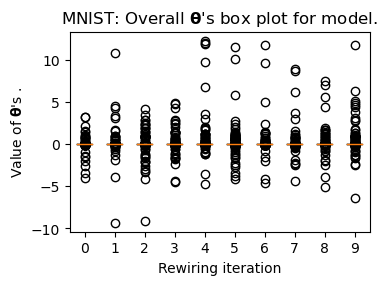

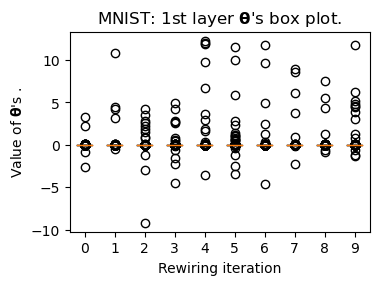

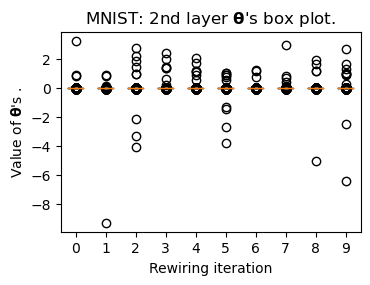

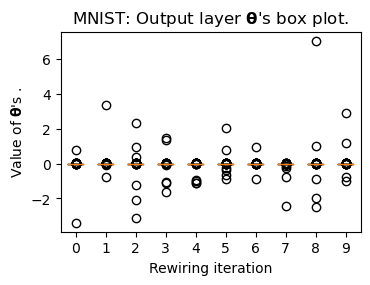

In [331]:
import itertools
import pdb
import collections

def flatten(weights):
    w = []
    for l in weights:
        if isinstance(l, collections.Iterable):
            w = w + flatten(l)
        else:
            w = w + [l]
    return w


all_weights = {}
boxplot_data = []
weights = [Rewiring_dict[i][-1] for i in range(10)]
for i,task in enumerate(weights):
    all_weights[i+1] = flatten(task)
    boxplot_data.append(all_weights[i+1])
import matplotlib
font = {'family' : 'normal',
        'weight'  : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (3,2))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(boxplot_data) 
ax.set_xlabel(r'Rewiring iteration')
plt.title(r"MNIST: Overall $\mathbf{\theta}$'s box plot for model.")
ax.set_ylabel(r"Value of $\mathbf{\theta}$'s .")
ax.set_xticklabels(list(range(10)))
#plt.savefig('MNIST_params_boxplot.pdf', bbox_inches='tight')
plt.show()

all_weights = {}
boxplot_data = []
weights = [Rewiring_dict[i][-1] for i in range(10)]
for i,task in enumerate(weights):
    for j,layer in enumerate(task):
        if j%2==0:
            all_weights[i+1] = flatten(layer)
            boxplot_data.append(all_weights[i+1])
            
first_layer_weights =  boxplot_data[0::3]
second_layer_weights = boxplot_data[1::3]
output_layer_weights = boxplot_data[2::3]

fig = plt.figure(figsize =(3, 2))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(first_layer_weights) 
ax.set_xlabel(r'Rewiring iteration')
plt.title(r"MNIST: 1st layer $\mathbf{\theta}$'s box plot.")
ax.set_ylabel(r"Value of $\mathbf{\theta}$'s .")
ax.set_xticklabels(list(range(10)))
#plt.savefig('MNIST_params_boxplot.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize =(3, 2))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(second_layer_weights) 
ax.set_xlabel(r'Rewiring iteration')
plt.title(r"MNIST: 2nd layer $\mathbf{\theta}$'s box plot.")
ax.set_ylabel(r"Value of $\mathbf{\theta}$'s .")
ax.set_xticklabels(list(range(10)))
#plt.savefig('MNIST_params_boxplot.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize =(3, 2))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(output_layer_weights) 
ax.set_xlabel(r'Rewiring iteration')
plt.title(r"MNIST: Output layer $\mathbf{\theta}$'s box plot.")
ax.set_ylabel(r"Value of $\mathbf{\theta}$'s .")
ax.set_xticklabels(list(range(10)))
#plt.savefig('MNIST_params_boxplot.pdf', bbox_inches='tight')
plt.show()

## 4. Sparsity and Layer size Tuning

In [338]:
len(list(zip(range(30,270,30),range(20,270,30))))

In [339]:
#Sweeping the sparsity and layersize (number of neurons in hidden layers) and measuring the model accuracy
model_losses = []
model_accs = []
Layerwise_sparsity = []
model_sparsity = []
Model_number_of_params = []
Model_weights_collection = []
for (first_layer_size,second_layer_size) in zip(range(30,270,30),range(20,270,30)):
    model = Sequential()
    model.add(Dense(first_layer_size, input_shape=(43,),kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Activation('relu'))                            
    model.add(Dense(second_layer_size,kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(Dense(10,kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Activation('softmax'))

    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    layerwise_sparsity = []
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    for sparsity in range(10):
        print(f'Model training for sparsity # {sparsity+1}, layer size {first_layer_size,second_layer_size}.')
        class LossHistory(keras.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.losses = []
                self.batches = []
                self.weight_save = []
                self.model_weights = model.get_weights()
                self.weight_masks = []
                for i in range(len(self.model_weights)):
                    if i%2 == 0:
                        self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                        for j in range(sparsity):
                            self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                        self.weight_masks.append(self.random_mask)
                for i in range(len(self.model_weights)):
                    if i == 0:
                        self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
                model.set_weights(self.model_weights)
                self.weight_save.append(model.get_weights)       

            def on_batch_end(self, batch, logs={}):
                self.losses.append(logs.get('loss'))
                self.batches.append(batch)
                self.model_weights = model.get_weights()
                for i in range(len(self.model_weights)):
                    if i %2 == 0:
                        self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
                model.set_weights(self.model_weights)
                self.weight_save.append(model.get_weights) 

        l_history=LossHistory()
        history = model.fit(X_train, Y_train,
                  batch_size=128, epochs=10, verbose=0,
                  validation_data=(X_test, Y_test), callbacks = [es, l_history])

        loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
        model_losses.append(loss_and_metrics[0])
        model_accs.append(loss_and_metrics[1])

        for i in range(len(model.get_weights())):
            if i%2==0:
                layerwise_sparsity.append(1 - (np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)
        model_sparsity.append(np.mean(layerwise_sparsity))
        Layerwise_sparsity.append(layerwise_sparsity)
        Model_number_of_params.append(model.count_params())
        Model_weights_collection.append(model.get_weights())
        layerwise_sparsity = []

Model_nonzero_params = []
Average_weight_val = []
for z,weight in enumerate(Model_weights_collection):
    print('Working on weights flattening for iter: ',z)
    flattened_weight_lst = flatten(weight)
    Model_nonzero_params.append(np.count_nonzero(flattened_weight_lst))
    Average_weight_val.append(np.mean(flattened_weight_lst))

Model training for sparsity # 1, layer size (30, 20).
2573/2573 - 1s - loss: 184155632.0000 - accuracy: 0.4106 - 1s/epoch - 580us/step
Model training for sparsity # 2, layer size (30, 20).
2573/2573 - 2s - loss: 66979052.0000 - accuracy: 0.4293 - 2s/epoch - 589us/step
Model training for sparsity # 3, layer size (30, 20).
2573/2573 - 2s - loss: 2.6198 - accuracy: 0.2742 - 2s/epoch - 727us/step
Model training for sparsity # 4, layer size (30, 20).
2573/2573 - 2s - loss: 3.4585 - accuracy: 0.4494 - 2s/epoch - 764us/step
Model training for sparsity # 5, layer size (30, 20).
2573/2573 - 1s - loss: 1.5917 - accuracy: 0.4494 - 1s/epoch - 571us/step
Model training for sparsity # 6, layer size (30, 20).
2573/2573 - 1s - loss: 1.5916 - accuracy: 0.4494 - 1s/epoch - 558us/step
Model training for sparsity # 7, layer size (30, 20).
2573/2573 - 1s - loss: 1.5867 - accuracy: 0.4494 - 1s/epoch - 580us/step
Model training for sparsity # 8, layer size (30, 20).
2573/2573 - 2s - loss: 1.5919 - accuracy: 

2573/2573 - 2s - loss: 1.6827 - accuracy: 0.4494 - 2s/epoch - 716us/step
Model training for sparsity # 7, layer size (150, 140).
2573/2573 - 2s - loss: 1.5899 - accuracy: 0.4494 - 2s/epoch - 766us/step
Model training for sparsity # 8, layer size (150, 140).
2573/2573 - 3s - loss: 1.5909 - accuracy: 0.4494 - 3s/epoch - 1ms/step
Model training for sparsity # 9, layer size (150, 140).
2573/2573 - 2s - loss: 1.5930 - accuracy: 0.4494 - 2s/epoch - 705us/step
Model training for sparsity # 10, layer size (150, 140).
2573/2573 - 2s - loss: 1.5912 - accuracy: 0.4494 - 2s/epoch - 828us/step
Model training for sparsity # 1, layer size (180, 170).
2573/2573 - 3s - loss: 318072768.0000 - accuracy: 0.1494 - 3s/epoch - 1ms/step
Model training for sparsity # 2, layer size (180, 170).
2573/2573 - 3s - loss: 757514944.0000 - accuracy: 0.1509 - 3s/epoch - 1ms/step
Model training for sparsity # 3, layer size (180, 170).
2573/2573 - 2s - loss: 192324896.0000 - accuracy: 0.3741 - 2s/epoch - 956us/step
Model

##### Plotting the metrics

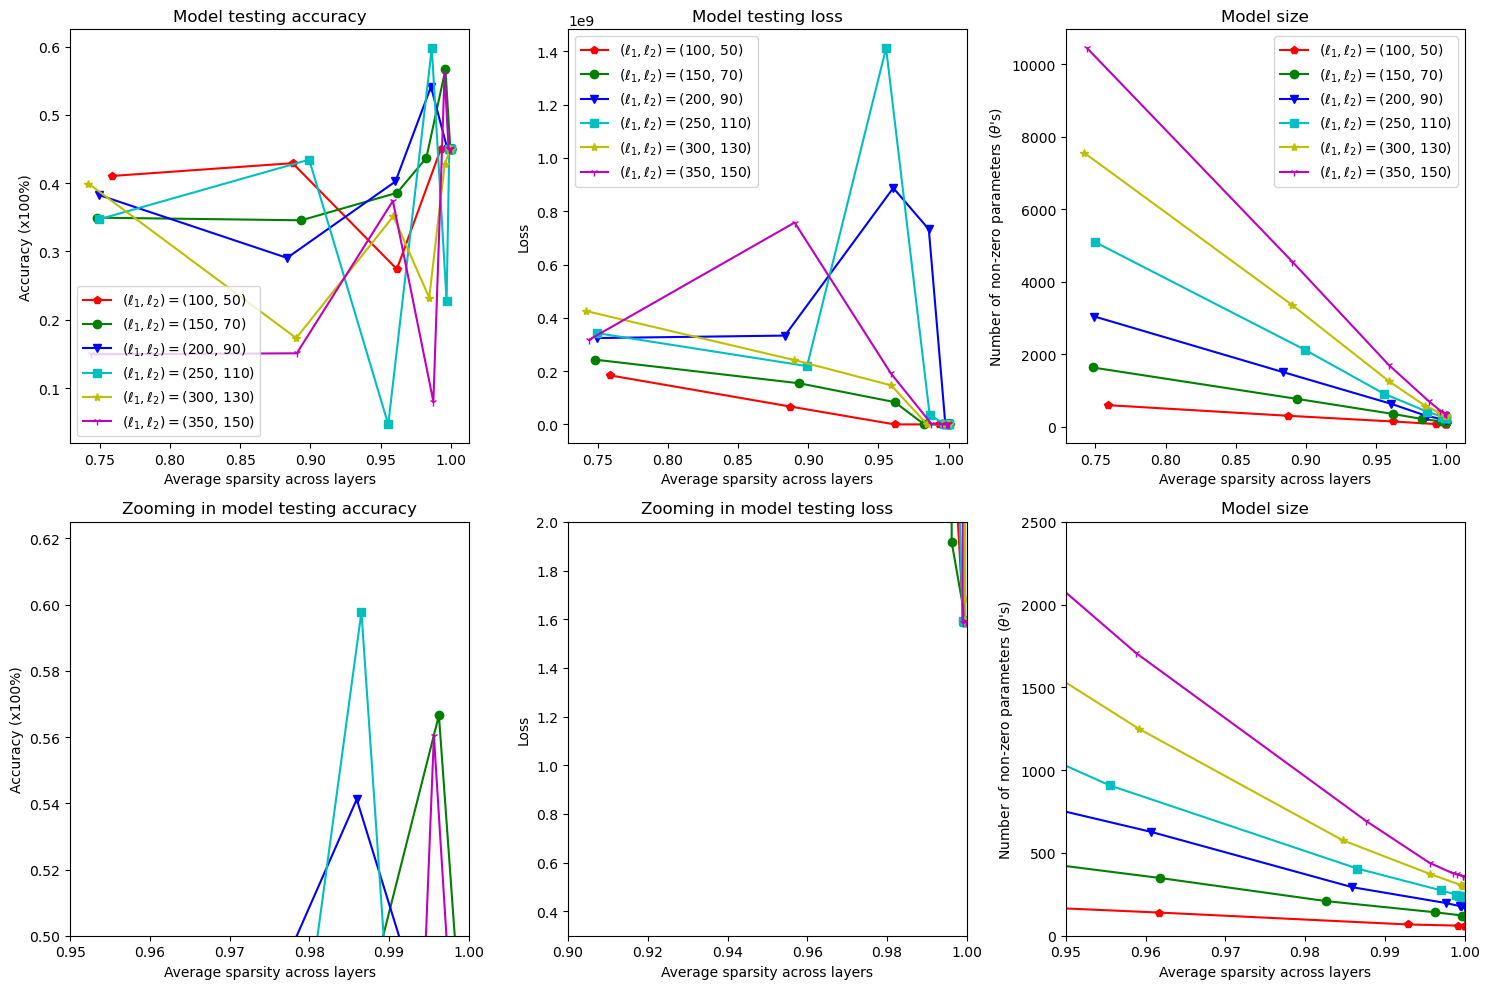

In [346]:
fig = plt.figure(figsize = (15,10))
sparsity_iters = 0
for (first_layer_size,second_layer_size,c,m) in zip(range(100,500,50),range(50,250,20),['r','g','b','c','y', 'm'],['p','o','v','s','*','1','2','3','4']):
    plt.subplot(2,3,1)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], model_accs[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title('Model testing accuracy')
    plt.grid()
    plt.ylabel('Accuracy (x100%)')
    plt.xlabel('Average sparsity across layers')
    plt.legend()
    
    plt.subplot(2,3,2)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], model_losses[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title('Model testing loss')
    plt.ylabel('Loss')
    plt.xlabel('Average sparsity across layers')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(2,3,4)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], model_accs[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title('Zooming in model testing accuracy')
    plt.grid()
    plt.ylabel('Accuracy (x100%)')
    plt.xlabel('Average sparsity across layers')
    plt.xlim(0.95,1)
    plt.ylim(0.5,0.625)
    #plt.legend()
    
    plt.subplot(2,3,5)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], model_losses[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title('Zooming in model testing loss')
    plt.ylabel('Loss')
    plt.xlabel('Average sparsity across layers')
    plt.grid()
    #plt.legend()
    plt.xlim(0.9,1)
    plt.ylim(0.3,2)
    plt.tight_layout()
    
    plt.subplot(2,3,3)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], Model_nonzero_params[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title('Model size')
    plt.grid()
    plt.ylabel(r"Number of non-zero parameters ($\theta$'s)")
    plt.xlabel('Average sparsity across layers')
    plt.legend()
    
    plt.subplot(2,3,6)
    plt.plot(model_sparsity[sparsity_iters*10:sparsity_iters*10+10], Model_nonzero_params[sparsity_iters*10:sparsity_iters*10+10], color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    plt.title('Model size')
    plt.grid()
    plt.ylabel(r"Number of non-zero parameters ($\theta$'s)")
    plt.xlabel('Average sparsity across layers')
    #plt.legend()
    plt.xlim(0.95,1)
    plt.ylim(0,2500)
    
    sparsity_iters = sparsity_iters+1

##### 3d plot

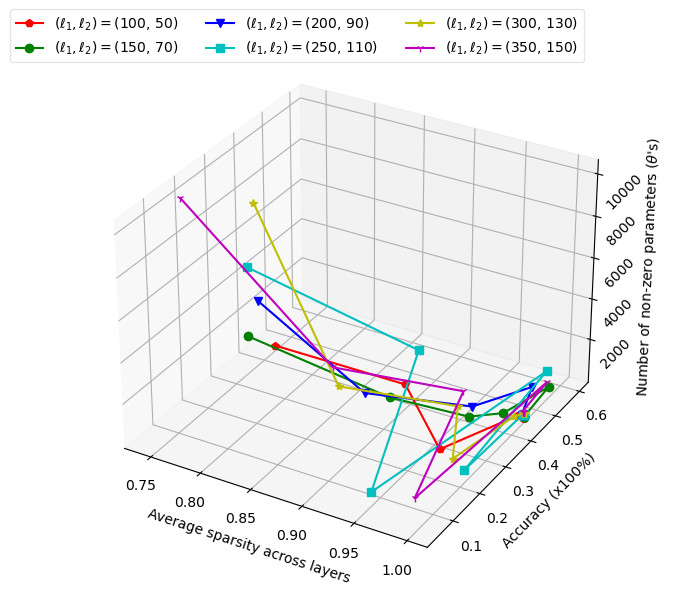

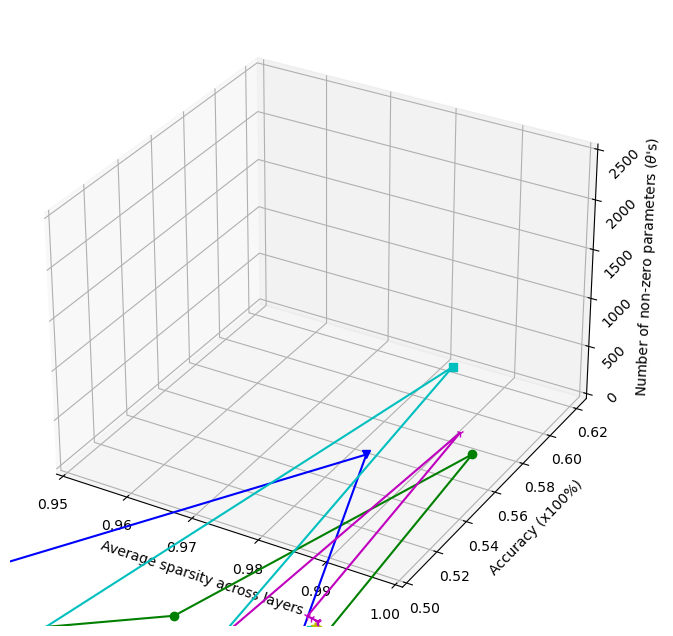

In [348]:
fig = plt.figure(figsize = (10,7))
ax = plt.axes(projection='3d')
sparsity_iters = 0
for (first_layer_size,second_layer_size,c,m) in zip(range(100,500,50),range(50,250,20),['r','g','b','c','y', 'm'],['p','o','v','s','*','1','2','3','4']):
    xline = model_sparsity[sparsity_iters*10:sparsity_iters*10+10]
    yline = model_accs[sparsity_iters*10:sparsity_iters*10+10]
    zline = Model_nonzero_params[sparsity_iters*10:sparsity_iters*10+10]
    ax.plot3D(xline, yline, zline, color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    #ax.set_title('Model testing accuracy vs sparsity vs no. of connections.')
    ax.grid()
    ax.set_ylabel('Accuracy (x100%)')
    ax.set_xlabel('Average sparsity across layers')
    ax.set_zlabel(r"Number of non-zero parameters ($\theta$'s)")
    for tick in ax.get_zticklabels():
        tick.set_rotation(45)
    ax.legend(ncol=3, loc='lower left', fancybox=True, framealpha=0.5, bbox_to_anchor=(-0.15, 0.950))
    sparsity_iters = sparsity_iters+1
    
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection='3d')
sparsity_iters = 0
for (first_layer_size,second_layer_size,c,m) in zip(range(100,500,50),range(50,250,20),['r','g','b','c','y', 'm'],['p','o','v','s','*','1','2','3','4']):
    xline = model_sparsity[sparsity_iters*10:sparsity_iters*10+10]
    yline = model_accs[sparsity_iters*10:sparsity_iters*10+10]
    zline = Model_nonzero_params[sparsity_iters*10:sparsity_iters*10+10]
    ax.plot3D(xline, yline, zline, color = c, marker = m, label = r'$(\ell_1,\ell_2)=$'+ f'{first_layer_size,second_layer_size}')
    #ax.set_title('Model testing accuracy vs sparsity vs no. of connections.')
    ax.grid()
    ax.set_ylabel('Accuracy (x100%)')
    ax.set_xlabel('Average sparsity across layers')
    ax.set_zlabel(r"Number of non-zero parameters ($\theta$'s)")
    for tick in ax.get_zticklabels():
        tick.set_rotation(45)
    #ax.legend(ncol=3, loc='lower left', fancybox=True, framealpha=0.5, bbox_to_anchor=(-0.15, 0.950))
    ax.set_xlim(0.95,1)
    ax.set_ylim(0.5,0.625)
    ax.set_zlim(0,2500)   
    sparsity_iters = sparsity_iters+1

##### Showing the summary of results as dataframe

In [358]:
import pandas as pd
df = pd.DataFrame(list(zip(list(range(100,500,50))*len(list(range(10))), list(range(50,250,20))*len(list(range(10))), model_sparsity, model_accs, model_losses, Model_nonzero_params, Model_number_of_params, Average_weight_val)),
               columns =[r'$\ell_1$', r'$\ell_1$', 'Sparsity', 'Validation Acc', 'Validation Loss', r'Nonzero $|\theta|$', r'$|\theta|$', r'Centroid of $\theta$' ])
print(df.to_string())

    $\ell_1$  $\ell_1$  Sparsity  Validation Acc  Validation Loss  Nonzero $|\theta|$  $|\theta|$  Centroid of $\theta$
0        100        50  0.758747        0.410569     1.841556e+08                 591        2150              0.027931
1        150        70  0.887390        0.429323     6.697905e+07                 297        2150              0.015815
2        200        90  0.961641        0.274158     2.619778e+00                 140        2150              0.003873
3        250       110  0.992855        0.449400     3.458538e+00                  68        2150              0.005785
4        300       130  0.999186        0.449400     1.591699e+00                  61        2150              0.001164
5        350       150  1.000000        0.449400     1.591601e+00                  59        2150              0.001157
6        400       170  1.000000        0.449400     1.586709e+00                  59        2150              0.001152
7        450       190  1.000000        

##### Finding the smallest network size with accuracy more than 50%.

In [360]:
df = df.sort_values(by=[r'Nonzero $|\theta|$', 'Validation Acc'], ascending=True)
print(f"The smallest network with accuracy more than 90% is:\n{df.loc[df['Validation Acc'] > 0.5].iloc[0]}")
print('\nOther options for the accuracy > 50% is:')
df.loc[df['Validation Acc'] > 0.5]

The smallest network with accuracy more than 90% is:
$\ell_1$                 400.000000
$\ell_1$                 130.000000
Sparsity                   0.996245
Validation Acc             0.566560
Validation Loss            1.915834
Nonzero $|\theta|$       142.000000
$|\theta|$              6200.000000
Centroid of $\theta$       0.003901
Name: 14, dtype: float64

Other options for the accuracy > 50% is:


,$\ell_1$,$\ell_1$,Sparsity,Validation Acc,Validation Loss,Nonzero $|\theta|$,$|\theta|$,Centroid of $\theta$
14,400,130,0.996245,0.566560,1.915834e+00,142,6200,0.003901
23,450,110,0.985937,0.541199,7.322420e+08,293,12050,0.008220
33,150,110,0.986527,0.597763,3.666613e+07,406,19700,0.002948
54,400,130,0.995619,0.560414,9.972437e+01,440,40400,0.001776
64,100,130,0.994543,0.543653,2.250110e+01,553,53450,0.001352
